# Addressing Question 2 & 3

## BRIEF INTRO: I want to perform unbiased clustering on the marker expression to see which diagnoses actually cluster nearest and farthest from each other according to surface protein expression. Then I will display the fraction of patients from each diagnostic category received chemotherapy as a treatment (vs. surgery or no treatment).

## Python pt 1: read in necesary dataframes and show basics of the data set


In [2]:
# Start with importing the packages
%matplotlib notebook

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE
from   sklearn.preprocessing import StandardScaler
import scipy
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-notebook'
pd.set_option('precision', 2)
pd.set_option('max_columns',10)

In [3]:
#Read in expression data set here as a data frame to manipulateand. If the below reading in does not work please
#use the commented out line below specifitying the file location - I had a lot of trouble with setting relative paths

data_df = pd.read_csv('../data/marker_expression.csv')

#data_df = pd.read_csv('/Users/dgranadi/Desktop/TCFB_2020/Capstone/data/marker_expression.csv')


data_df.head()

,ck5,ck7,ck17,ck18,ck19,...,chra,cd56,cd10,clin_diag,pad
0,0.00,92.5,20.00,92.5,92.5,...,0.0,0.00,0.00,Ductal pancreatic adenocarcinoma,Pancreas Ac|397
1,0.00,20.0,0.00,92.5,50.0,...,0.0,0.00,0.00,Hepatocellular carcinoma,Hepatocellular Cancer|190
2,0.00,92.5,0.00,92.5,92.5,...,2.5,0.00,0.00,Ductal pancreatic adenocarcinoma,Pancreas Ac|25
3,0.71,70.0,18.33,92.5,85.0,...,0.0,10.00,9.17,Gallbladder cancer,Gallbladder Ac|108
4,0.00,0.0,0.00,92.5,40.0,...,0.0,11.56,0.00,Hepatocellular carcinoma,Hepatocellular Cancer|336


In [4]:
#Remove the patient identifying colun for the time being
grouped_df = data_df
del grouped_df['pad']

grouped_df


,ck5,ck7,ck17,ck18,ck19,...,smad4,chra,cd56,cd10,clin_diag
0,0.00,92.5,20.00,92.5,92.5,...,0.00,0.0,0.00,0.00,Ductal pancreatic adenocarcinoma
1,0.00,20.0,0.00,92.5,50.0,...,90.00,0.0,0.00,0.00,Hepatocellular carcinoma
2,0.00,92.5,0.00,92.5,92.5,...,70.00,2.5,0.00,0.00,Ductal pancreatic adenocarcinoma
3,0.71,70.0,18.33,92.5,85.0,...,42.50,0.0,10.00,9.17,Gallbladder cancer
4,0.00,0.0,0.00,92.5,40.0,...,58.78,0.0,11.56,0.00,Hepatocellular carcinoma
...,...,...,...,...,...,...,...,...,...,...,...
434,0.00,80.0,60.00,85.0,92.5,...,90.00,5.0,0.00,5.00,Distal bile duct cancer
435,0.00,60.0,30.00,92.5,92.5,...,95.00,0.0,0.00,0.00,Perihilar cholangiocarcinoma
436,50.00,92.5,92.50,92.5,92.5,...,85.00,0.0,0.00,0.00,Ductal pancreatic adenocarcinoma
437,0.00,92.5,0.00,92.5,92.5,...,95.00,0.0,0.00,0.00,Intrahepatic cholangiocarcinoma


In [5]:
#Show the basic marker stats for each diagnosis just a sa proof of principle here

diagnosis_set = set(grouped_df['clin_diag'])


for diagnosis in diagnosis_set:
    print('stats for diagnosis', diagnosis)
    print(grouped_df[ grouped_df['clin_diag'] == diagnosis].describe())

stats for diagnosis Ampullary carcinoma
         ck5    ck7   ck17   ck18   ck19  ...   ki67  smad4   chra   cd56  \
count  24.00  24.00  24.00  24.00  24.00  ...  24.00  24.00  24.00  24.00   
mean    1.75  59.09  10.04  90.25  91.98  ...  50.00  62.11   0.97   0.43   
std     3.90  39.44   9.60   5.33   2.55  ...  20.64  36.06   1.77   1.25   
min     0.00   0.00   0.00  70.00  80.00  ...  10.00   0.00   0.00   0.00   
25%     0.00  16.25   0.00  91.88  92.50  ...  30.00  45.00   0.00   0.00   
50%     0.00  80.00   5.00  92.50  92.50  ...  45.00  85.00   0.00   0.00   
75%     0.47  92.50  15.00  92.50  92.50  ...  70.00  85.00   0.94   0.00   
max    15.00  92.50  30.00  92.50  92.50  ...  80.00  95.00   5.00   5.00   

        cd10  
count  24.00  
mean   11.80  
std    25.66  
min     0.00  
25%     0.00  
50%     2.50  
75%     7.32  
max    92.50  

[8 rows x 27 columns]
stats for diagnosis Hepatocellular carcinoma
          ck5     ck7    ck17    ck18   ck19  ...    ki67   sma

In [6]:
#Group by diagnosis and show that you can generate a csv file containing all the stats for each marker by diagnosis

summary_df = grouped_df.groupby('clin_diag').describe()
select_markers = summary_df.loc[: , ['ca125' , 'cd56' , 'ck7' , 'muc2' , 'cd10']]
print(select_markers)
select_markers.to_csv('Differentially_Expressed_Markers.csv')

                                    ck7                             ... cd10  \
                                  count   mean    std   min    25%  ...  min   
clin_diag                                                           ...        
Ampullary carcinoma                24.0  59.09  39.44   0.0  16.25  ...  0.0   
Distal bile duct cancer             8.0  83.12  21.91  30.0  89.38  ...  0.0   
Ductal pancreatic adenocarcinoma  143.0  81.93  26.84   0.0  92.50  ...  0.0   
Gallbladder cancer                 38.0  76.02  30.81   0.0  72.50  ...  0.0   
Hepatocellular carcinoma          100.0  10.50  21.77   0.0   0.00  ...  0.0   
Intrahepatic cholangiocarcinoma    98.0  81.18  26.26   0.0  92.50  ...  0.0   
Perihilar cholangiocarcinoma       28.0  69.53  35.31   0.0  63.71  ...  0.0   

                                                             
                                   25%    50%    75%    max  
clin_diag                                                    
Ampullary car

In [7]:
#SCRATCH CELL

#Show_counts = grouped_df['clin_diag'].value_counts()

#print(Show_counts)

#plt.figure(figsize=(6, 5))
#Show_counts.plot.bar()
#plt.xticks(fontsize=10)



## Question 2: Create a PCA to show differences between diagnosis clusters and create a tsne to show which diagnoses cluster nearest and are most related

In [8]:
# Here we are going to set up a dictionary that maps diagnoses to plotting colors

set_of_diagnoses = set( grouped_df['clin_diag'] ) # get rid of duplicates in the species column

color_dict = {}

# zip is a useful builtin function that takes two lists/sets/sequences and 
#  lets you loop over them at the same time


for diagnosis, color in zip( set_of_diagnoses, 'rgbymck' ):
    print(diagnosis, color)
    color_dict[ diagnosis ] = color
    
print(color_dict)


Ampullary carcinoma r
Hepatocellular carcinoma g
Ductal pancreatic adenocarcinoma b
Perihilar cholangiocarcinoma y
Distal bile duct cancer m
Intrahepatic cholangiocarcinoma c
Gallbladder cancer k
{'Ampullary carcinoma': 'r', 'Hepatocellular carcinoma': 'g', 'Ductal pancreatic adenocarcinoma': 'b', 'Perihilar cholangiocarcinoma': 'y', 'Distal bile duct cancer': 'm', 'Intrahepatic cholangiocarcinoma': 'c', 'Gallbladder cancer': 'k'}


In [9]:
# now let's use this dictionary to make a new column for the iris dataframe, containing the colors
colors = []
for diagnosis in grouped_df['clin_diag']:
    colors.append(color_dict[diagnosis])

print(colors[:5])


['b', 'g', 'b', 'k', 'g']


In [10]:
grouped_df['color'] = colors 
grouped_df.head()

,ck5,ck7,ck17,ck18,ck19,...,chra,cd56,cd10,clin_diag,color
0,0.00,92.5,20.00,92.5,92.5,...,0.0,0.00,0.00,Ductal pancreatic adenocarcinoma,b
1,0.00,20.0,0.00,92.5,50.0,...,0.0,0.00,0.00,Hepatocellular carcinoma,g
2,0.00,92.5,0.00,92.5,92.5,...,2.5,0.00,0.00,Ductal pancreatic adenocarcinoma,b
3,0.71,70.0,18.33,92.5,85.0,...,0.0,10.00,9.17,Gallbladder cancer,k
4,0.00,0.0,0.00,92.5,40.0,...,0.0,11.56,0.00,Hepatocellular carcinoma,g


In [11]:
X_df = grouped_df.drop(['clin_diag','color'], axis=1)
X_df.shape

(439, 27)

In [12]:
from sklearn.decomposition import PCA # sklearn == scikit-learn package name

# This is the general scikit-learn workflow
# Step 1. create and configure the model:
pca = PCA(n_components=7)

# Step 2. fit the model to the data
pca.fit(X_df)


PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [13]:
print(pca.components_)

[[-0.0197 -0.3505 -0.1448 -0.0149 -0.3213 -0.0159 -0.026  -0.2282 -0.0142
  -0.2203 -0.0295 -0.3344 -0.3342 -0.2349 -0.2231 -0.2448 -0.334  -0.3095
   0.0069 -0.0729 -0.1283 -0.0097 -0.0587  0.1612 -0.0022  0.0234  0.0464]
 [ 0.0107  0.2256 -0.0242  0.0254  0.1994 -0.1155  0.4794  0.3396 -0.0721
  -0.3107  0.0443  0.1818  0.1554 -0.3794 -0.062  -0.1314  0.0295 -0.2406
   0.142  -0.1655 -0.0536  0.0144 -0.0057  0.3285 -0.0062  0.0713 -0.0335]
 [-0.0563  0.032  -0.3316  0.061   0.2105  0.1735 -0.1588 -0.3303  0.109
  -0.0078  0.0865  0.3005  0.1537  0.0854  0.1604 -0.5446  0.0081 -0.0783
  -0.0174  0.3135  0.0908 -0.0746  0.0931  0.2655  0.0121  0.032   0.1073]
 [ 0.02    0.0155  0.0685  0.0178 -0.0383 -0.0076  0.0934 -0.0305 -0.0204
   0.0426  0.0184 -0.0072 -0.0378 -0.0647 -0.1432  0.0403 -0.211  -0.0771
   0.0522  0.0349  0.9294  0.0392  0.1538 -0.0138  0.003  -0.0344 -0.0896]
 [ 0.0437 -0.348   0.0851 -0.0028  0.0485  0.2522  0.2517  0.1553  0.1151
  -0.2084 -0.05   -0.067  -0.0322  

In [14]:
X_pca = pca.transform(X_df)
X_pca.shape

(439, 7)

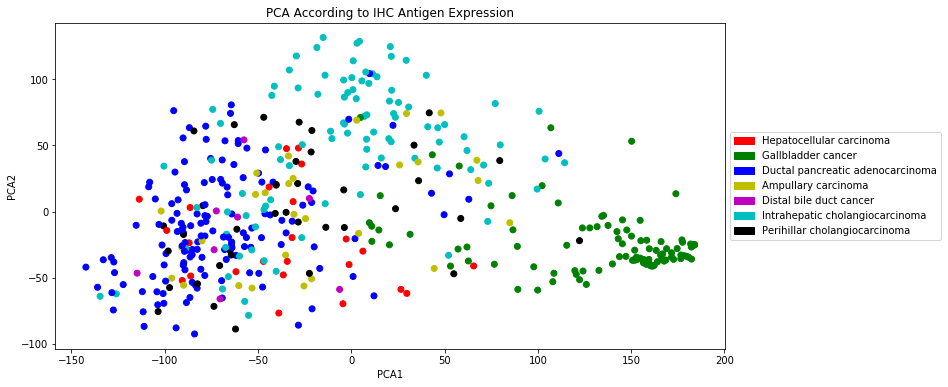

In [15]:
# Now the first two columns of X_pca represent the axes of 
#  greatest variation, so we can plot just those and retain
#  the maximum information.
%matplotlib inline
plt.figure(figsize=(12, 6))
#plt.scatter( X_pca[:,0], X_pca[:,1], c=colors )
plt.title('PCA According to IHC Antigen Expression')
plt.xlabel('PCA1')
plt.ylabel('PCA2'); # so notebook doesn't print the Text object returned by plt.ylabel
plt.scatter( X_pca[:,0], X_pca[:,1], c=colors )
#plt.legend(grouped_df['clin_diag'])
#plt.legend(handles = color_dict.values() , labels = color_dict.keys())


import matplotlib.patches as mpatches


red_patch = mpatches.Patch(color='r', label='Hepatocellular carcinoma')
green_patch = mpatches.Patch(color='g', label='Gallbladder cancer')
blue_patch = mpatches.Patch(color='b', label='Ductal pancreatic adenocarcinoma')
yellow_patch = mpatches.Patch(color='y', label='Ampullary carcinoma')
m_patch = mpatches.Patch(color='m', label='Distal bile duct cancer')
c_patch = mpatches.Patch(color='c', label='Intrahepatic cholangiocarcinoma')
k_patch = mpatches.Patch(color='k', label='Perihillar cholangiocarcinoma')

plt.gca().legend(handles=[red_patch , green_patch , blue_patch , yellow_patch, m_patch, c_patch , k_patch] , loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

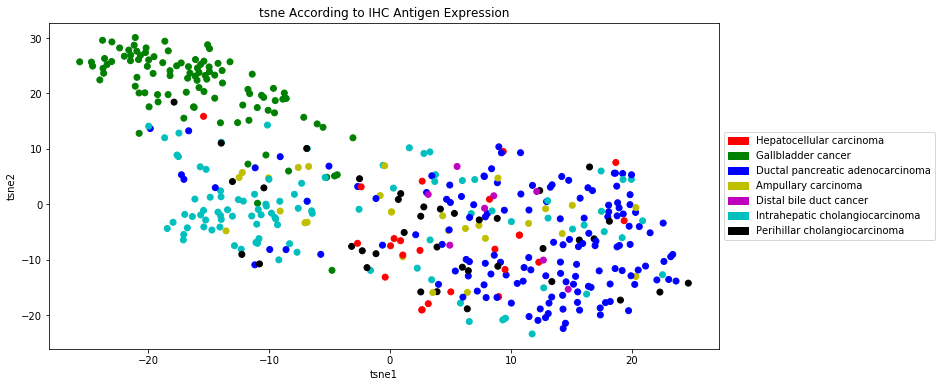

In [16]:
from sklearn.manifold import TSNE

# 1. create the TSNE object, call it tsne. Tell it you want 2 components (ie, a 2D projection) 

tsne = TSNE(n_components=2)

# 2. Fit the data to the model and transform to a new array (call it X_tsne) using tsne.fit_transform
#     This combines the fit and transform steps into a single operation.

X_tsne = tsne.fit_transform(X_df)


# Use this matplotlib command to make a scatter plot of the two components, colored by the 
#  kmeans cluster assignments
plt.figure(figsize=(12, 6))
plt.scatter( X_tsne[:,0], X_tsne[:,1], c=colors )

plt.title('tsne According to IHC Antigen Expression')
plt.xlabel('tsne1')
plt.ylabel('tsne2');
plt.legend(grouped_df['clin_diag'])

red_patch = mpatches.Patch(color='r', label='Hepatocellular carcinoma')
green_patch = mpatches.Patch(color='g', label='Gallbladder cancer')
blue_patch = mpatches.Patch(color='b', label='Ductal pancreatic adenocarcinoma')
yellow_patch = mpatches.Patch(color='y', label='Ampullary carcinoma')
m_patch = mpatches.Patch(color='m', label='Distal bile duct cancer')
c_patch = mpatches.Patch(color='c', label='Intrahepatic cholangiocarcinoma')
k_patch = mpatches.Patch(color='k', label='Perihillar cholangiocarcinoma')

plt.gca().legend(handles=[red_patch , green_patch , blue_patch , yellow_patch, m_patch, c_patch , k_patch] , loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### According to PCA, Hepatocellular carcinoma and Ductal Pancreatic adenocarcinoma are the most dissimilar and tsne shows that several of the dianoses are closely related according to surface marker expression but (by eye, at least)

## Question 3: How many patients from each diagnosis received chemotherapy

In [17]:
#Read in clinical data and expression data one more time (had to read it in again for troubleshooting purposes)

clinical_df = pd.read_csv('/Users/dgranadi/Desktop/TCFB_2020/Capstone/data/clinicaldata.csv')

clinical_df.head()

expression_data = pd.read_csv('/Users/dgranadi/Desktop/TCFB_2020/Capstone/data/marker_expression.csv')

expression_data.head()

,ck5,ck7,ck17,ck18,ck19,...,chra,cd56,cd10,clin_diag,pad
0,0.00,92.5,20.00,92.5,92.5,...,0.0,0.00,0.00,Ductal pancreatic adenocarcinoma,Pancreas Ac|397
1,0.00,20.0,0.00,92.5,50.0,...,0.0,0.00,0.00,Hepatocellular carcinoma,Hepatocellular Cancer|190
2,0.00,92.5,0.00,92.5,92.5,...,2.5,0.00,0.00,Ductal pancreatic adenocarcinoma,Pancreas Ac|25
3,0.71,70.0,18.33,92.5,85.0,...,0.0,10.00,9.17,Gallbladder cancer,Gallbladder Ac|108
4,0.00,0.0,0.00,92.5,40.0,...,0.0,11.56,0.00,Hepatocellular carcinoma,Hepatocellular Cancer|336


In [18]:
#Merge the clinical data with the expression data based on patient identifier

df_treatment = expression_data.merge(clinical_df, how='inner', on='pad')

#remove values that don't hae treatment data in the clinical data 

df_treatment2 = df_treatment[df_treatment.chemo != 'NaN']
df_treatment2


diagnosis_tx = df_treatment2.loc[: , ['clin_diag' , 'chemo']]
diagnosis_tx
                                  
 

,clin_diag,chemo
0,Ductal pancreatic adenocarcinoma,y
1,Hepatocellular carcinoma,n
2,Ductal pancreatic adenocarcinoma,n
3,Gallbladder cancer,n
4,Hepatocellular carcinoma,n
...,...,...
386,Distal bile duct cancer,n
387,Perihilar cholangiocarcinoma,n
388,Ductal pancreatic adenocarcinoma,y
389,Intrahepatic cholangiocarcinoma,y


In [19]:
#Create variable for the diagnosis counts
numb_diagnoses = len(diagnosis_tx.query("clin_diag == 'Ductal pancreatic adenocarcinoma'"))

In [20]:
#Create variable for the count for patients that received chemo within a particular diagnosis
numb_chemo = len(diagnosis_tx.query("clin_diag == 'Ductal pancreatic adenocarcinoma' & chemo == 'y'"))

In [21]:
#Make for loop that will go through each diagnosis and print out the percentage of those patients that received chemo

diagnoses = ['Ductal pancreatic adenocarcinoma' , 'Hepatocellular carcinoma' , 'Gallbladder cancer' , 'Distal bile duct cancer' , 'Perihilar cholangiocarcinoma' , 'Intrahepatic cholangiocarcinoma' , 'Ampullary carcinoma']


for diagnosis in diagnoses:
    count_diagnosis = (len(diagnosis_tx.query("clin_diag == @diagnosis")))
    count_chemo = (len(diagnosis_tx.query("clin_diag == @diagnosis & chemo == 'y'")))
    proportions = (diagnosis , count_chemo/count_diagnosis*100)
    
    print(proportions)
    
   


('Ductal pancreatic adenocarcinoma', 48.837209302325576)
('Hepatocellular carcinoma', 13.333333333333334)
('Gallbladder cancer', 44.11764705882353)
('Distal bile duct cancer', 42.857142857142854)
('Perihilar cholangiocarcinoma', 42.30769230769231)
('Intrahepatic cholangiocarcinoma', 47.42268041237113)
('Ampullary carcinoma', 47.82608695652174)


In [22]:
#Manually made a dataframe of the above data for % chemo

import matplotlib.pyplot as plot
d = {'Diagnosis': ['Ductal pancreatic adenocarcinoma' , 'Hepatocellular carcinoma' , 'Gallbladder cancer' , 'Distal bile duct cancer' , 'Perihilar cholangiocarcinoma' , 'Intrahepatic cholangiocarcinoma' , 'Ampullary carcinoma'], 'Percent Chemo': [48.84 , 13.33 , 44.12 , 42.85 , 42.30 , 47.42 , 47.83]}
plotting = pd.DataFrame(data=d)
plotting



,Diagnosis,Percent Chemo
0,Ductal pancreatic adenocarcinoma,48.84
1,Hepatocellular carcinoma,13.33
2,Gallbladder cancer,44.12
3,Distal bile duct cancer,42.85
4,Perihilar cholangiocarcinoma,42.30
5,Intrahepatic cholangiocarcinoma,47.42
6,Ampullary carcinoma,47.83


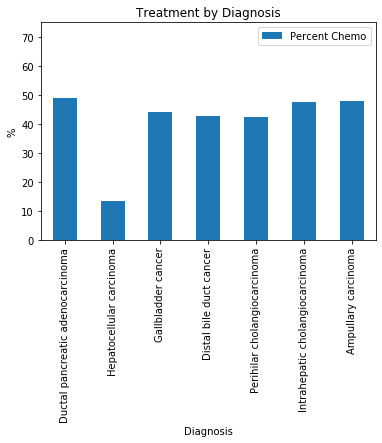

In [23]:
#Make bar chart showing the percentage of patients that receive chemo for each diagnosis
plotting.plot(x ='Diagnosis', y='Percent Chemo', kind = 'bar' )

plt.title('Treatment by Diagnosis')

plt.ylabel('%');

plt.ylim(0, 75)

plt.show()